In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from sklearn.model_selection import train_test_split
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA

from sklearn.metrics import mean_squared_error

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


# Read input data and data cleaning

In [2]:
df = pd.read_csv('DCOILBRENTEU.csv')
print("The shape of the dataframe is {}".format(df.shape))
print("The datatypes of the components in the dataframe are ")
print(df.dtypes)
df.head()

The shape of the dataframe is (8184, 2)
The datatypes of the components in the dataframe are 
DATE            object
DCOILBRENTEU    object
dtype: object


,DATE,DCOILBRENTEU
0,1987-05-20,18.63
1,1987-05-21,18.45
2,1987-05-22,18.55
3,1987-05-25,18.60
4,1987-05-26,18.63


In [3]:
# The data consists of '.' indicating missing data points, so these points can be eliminated
df = df[df.DCOILBRENTEU != "."]

# Convert the timestamp to datetime format and price to numeric format
df['Date'] = pd.to_datetime(df.DATE)
df['Price'] = pd.to_numeric(df.DCOILBRENTEU)

# The columns are renamed to 'Date' and 'Price' so older ones can be deleted
df.drop(['DATE','DCOILBRENTEU'],axis=1,inplace=True)

# Index the data as per the timestamp
df.set_index('Date')
df.head()

,Date,Price
0,1987-05-20,18.63
1,1987-05-21,18.45
2,1987-05-22,18.55
3,1987-05-25,18.60
4,1987-05-26,18.63


# Data Visualization

In [4]:
df.describe()

,Price
count,7963.000000
mean,45.721137
std,33.014491
min,9.100000
25%,18.630000
50%,29.950000
75%,66.970000
max,143.950000


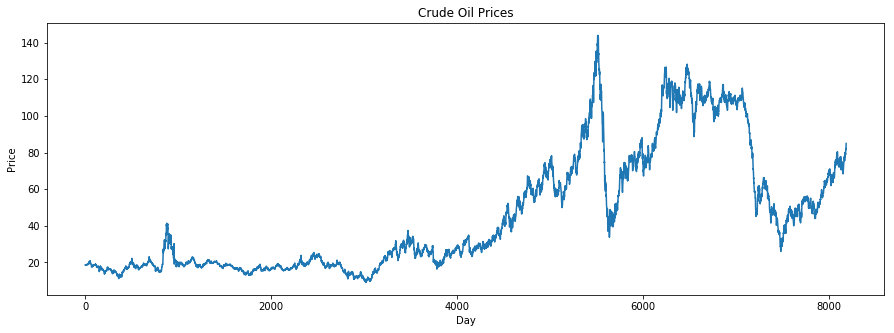

In [5]:
plt.figure(figsize=[15,5])
plt.plot(df['Price'])
plt.title('Crude Oil Prices')
plt.xlabel('Day')
plt.ylabel('Price')
plt.show()

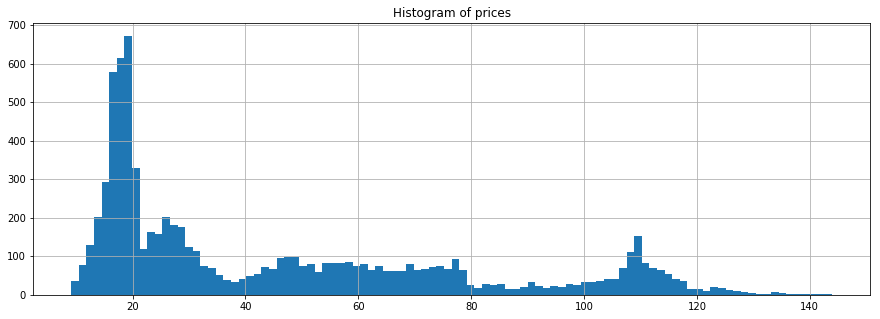

In [6]:
# Plot histogram of crude oil prices
plt.figure(figsize=[15,5])
df.Price.hist(bins = 100)
plt.title('Histogram of prices')
plt.show()

# Check for stationarity of data

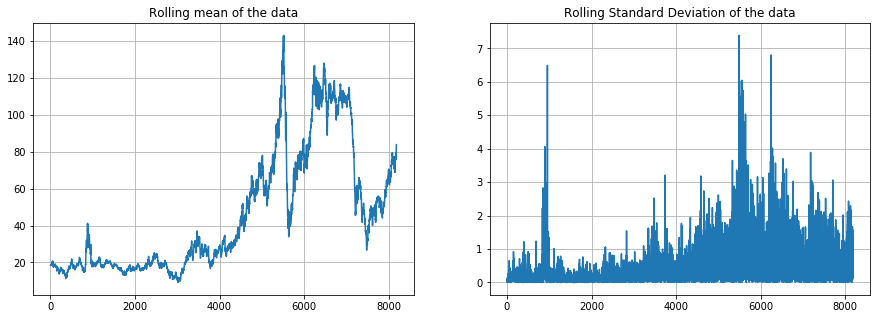

In [7]:
# Plot Rolling mean of crude oil prices to observe trends
plt.figure(figsize=[15,5])
plt.subplot(121)
df.Price.rolling(window = 2).mean().plot()
plt.title('Rolling mean of the data')
plt.grid()

#Plot rolling standard deviation of crude oil prices to observe variations
plt.subplot(122)
df.Price.rolling(window = 2).std().plot()
plt.title('Rolling Standard Deviation of the data')
plt.grid()
plt.show()

In [8]:
p_value=adfuller(df['Price'])[1]
print("The p-value for AD Fuller Test is {}".format(p_value))

The p-value for AD Fuller Test is 0.4277258639290178


It can be seen that data is not stationary as the p-value is above 0.05 and thus null hypothesis cannot be rejected. In addition to this, the rolling mean and rolling standard deviation plots validate that data is not stationary

# Induce stationarity in data

In [9]:
# Consider first order differencing to induce stationarity

stat_data = df.Price - df.Price.shift()
stat_data.dropna(inplace=True)

In [10]:
# Perform ADF test on the first order differenced data to check if stationarity is induced
result = adfuller(stat_data, autolag='AIC')
result_map = pd.Series(result[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in result[4].items():
    result_map['Critical Value (%s)'%key] = value
print (result_map)

Test Statistic                -1.297982e+01
p-value                        2.959754e-24
#Lags Used                     3.400000e+01
Number of Observations Used    7.927000e+03
Critical Value (1%)           -3.431175e+00
Critical Value (5%)           -2.861905e+00
Critical Value (10%)          -2.566964e+00
dtype: float64


The p-value is below 0.05 indicating that data has become stationary after log transform and first order differencing

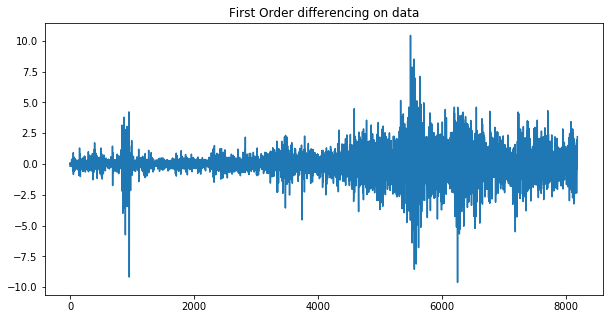

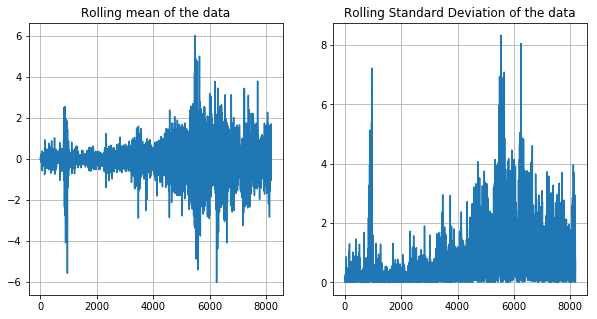

In [11]:
# Plot the stationary data
plt.figure(figsize=[10,5])
plt.plot(stat_data)
plt.title('First Order differencing on data')
plt.show()

# Plot Rolling mean of the stationary data
plt.figure(figsize=[10,5])
plt.subplot(121)
stat_data.rolling(window = 2).mean().plot()
plt.title('Rolling mean of the data')
plt.grid()

#Plot rolling standard deviation of the stationary data
plt.subplot(122)
stat_data.rolling(window = 2).std().plot()
plt.title('Rolling Standard Deviation of the data')
plt.grid()
plt.show()

The rolling mean and rolling standard deviation validate that data has become stationary after transformations

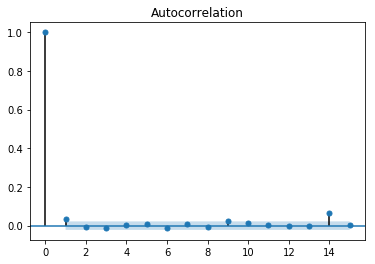

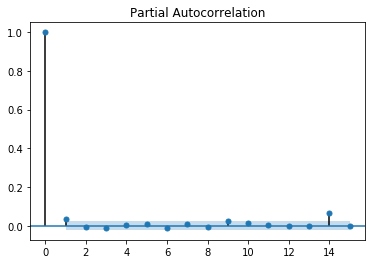

In [12]:
# Plot ACF and PACF to observe lag dependency in data
plot_acf(stat_data,lags=15)
plot_pacf(stat_data,lags=15)
plt.show()

### Split data into training and test dataset

In [13]:
# Split 90 % of data into training dataset and remaining for test dataset
split_value = round(df.shape[0]*0.9)
train = df.Price[:split_value]
test = df.Price[split_value:]

It can be seen that first order differencing can induce stationarity in the data so the d-parameter in ARIMA can be set to 1

In [14]:
# model = ARIMA(np.log(scaled_train_data.values),order=(4,1,4))
model = ARIMA(train.values,order=(4,1,4))
model_fit = model.fit()
predictions = model_fit.forecast(test.shape[0])

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\kalmanf\kalmanfilter.py:646: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\kalmanf\kalmanfilter.py:650: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  elif issubdtype(paramsdtype, complex):
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\kalmanf\kalmanfilter.py:577: FutureWarning: Conversion of the second argument of issubdtype from `float` to 

In [15]:
# predicted = unscale_data(predictions[0],min_val,max_val,a=0.1,b=0.9)
predicted = predictions[0]
actual = test.values

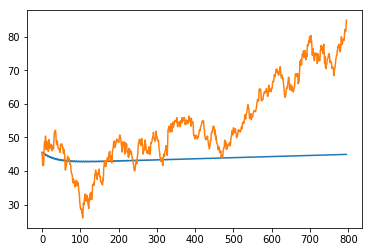

In [16]:
plt.plot(predicted,label='Predictions')
plt.plot(actual,label='Actual')

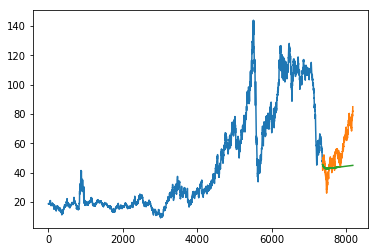

In [17]:
plt.plot(train)
plt.plot(test)
plt.plot(test.index,predicted)

It can be ntoed that linear methods like ARIMA are not able to model the trend in crude oil prices. So further, we can explore non-linear techniques like neural networks

# Prediction using LSTM

Recurrent neural networks are known to model sequential time series data like oil prices properly. So, Long Short Term Memory (LSTM) can be used to essentially identify the nonlinear trends in the data

# Split data into training and test dataset
Select training dataset size as per the batch size (mulitple of batch size) and test size is selected approximately as 10 % of the datase

In [18]:
# Batch size for updating weights
batch_size = 64

# Training epochs for the model
epochs = 120

# Sequence length for the input
timesteps = 30

# Split fraction for train-test data
test_split_fraction = 0.1

In [19]:
train_length = round(df.shape[0]*(1-test_split_fraction))

# Training dataset should be multiple of batch-size
while train_length%batch_size!=0:
    train_length=train_length-1
print("Consider {} training samples".format(train_length))

Consider 7104 training samples


In [20]:
# Add data for 2 sequences as for input for first batch and output for last batch
train_len_updated = train_length + timesteps*2
df_train = df.iloc[0:train_len_updated,1:2]

In [21]:
# Feature Scaling using minimum and maximum value from training data
from sklearn.preprocessing import MinMaxScaler
scale = MinMaxScaler(feature_range = (0, 1))
df_train_scaled = scale.fit_transform(np.float64(df_train))

### Creating batches for training

In [22]:
X_train = []
y_train = []

for i in range(timesteps, train_length + timesteps): 
    X_train.append(df_train_scaled[i-timesteps:i,0])
    y_train.append(df_train_scaled[i:i+timesteps,0])

X_train, y_train = np.array(X_train), np.array(y_train)

# Reshape data as per requirement for Keras model
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
y_train = np.reshape(y_train, (y_train.shape[0], y_train.shape[1], 1))
print(X_train.shape)
print(y_train.shape)

(7104, 30, 1)
(7104, 30, 1)


### Create Keras model

In [23]:
from keras.layers import Dense
from keras.layers import Input, LSTM
from keras.models import Model
from keras import losses

C:\ProgramData\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [24]:
input_layer = Input(batch_shape=(batch_size,timesteps,1))
lstm_1 = LSTM(10, stateful=True, return_sequences=True)(input_layer)
lstm_2 = LSTM(10, stateful=True, return_sequences=True)(lstm_1)
output_layer = Dense(units = 1)(lstm_2)

price_predictor = Model(inputs=input_layer, outputs = output_layer)

price_predictor.compile(optimizer='adam', loss = losses.mean_squared_error)
price_predictor.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (64, 30, 1)               0         
_________________________________________________________________
lstm_1 (LSTM)                (64, 30, 10)              480       
_________________________________________________________________
lstm_2 (LSTM)                (64, 30, 10)              840       
_________________________________________________________________
dense_1 (Dense)              (64, 30, 1)               11        
Total params: 1,331
Trainable params: 1,331
Non-trainable params: 0
_________________________________________________________________


In [25]:
# Train the network for the number of epochs as specified earlier
for epoch in range(epochs):
    print("Epoch: " + str(epoch))
    price_predictor.fit(X_train, y_train, shuffle=False, epochs = 1, batch_size = batch_size)
    price_predictor.reset_states()

Epoch: 0
Epoch 1/1
7104/7104 [==============================] - 4s 551us/step - loss: 0.0063
Epoch: 1
Epoch 1/1
7104/7104 [==============================] - 2s 298us/step - loss: 0.0083
Epoch: 2
Epoch 1/1
7104/7104 [==============================] - 2s 268us/step - loss: 0.0097
Epoch: 3
Epoch 1/1
7104/7104 [==============================] - 2s 271us/step - loss: 0.0091
Epoch: 4
Epoch 1/1
7104/7104 [==============================] - 2s 276us/step - loss: 0.0082
Epoch: 5
Epoch 1/1
7104/7104 [==============================] - 2s 281us/step - loss: 0.0072
Epoch: 6
Epoch 1/1
7104/7104 [==============================] - 2s 277us/step - loss: 0.0063
Epoch: 7
Epoch 1/1
7104/7104 [==============================] - 2s 263us/step - loss: 0.0056
Epoch: 8
Epoch 1/1
7104/7104 [==============================] - 2s 262us/step - loss: 0.0051
Epoch: 9
Epoch 1/1
7104/7104 [==============================] - 2s 274us/step - loss: 0.0047
Epoch: 10
Epoch 1/1
7104/7104 [==============================] - 2s 27

7104/7104 [==============================] - 2s 226us/step - loss: 0.0027
Epoch: 87
Epoch 1/1
7104/7104 [==============================] - 2s 264us/step - loss: 0.0028
Epoch: 88
Epoch 1/1
7104/7104 [==============================] - 1s 198us/step - loss: 0.0026
Epoch: 89
Epoch 1/1
7104/7104 [==============================] - 1s 195us/step - loss: 0.0027
Epoch: 90
Epoch 1/1
7104/7104 [==============================] - 2s 213us/step - loss: 0.0026
Epoch: 91
Epoch 1/1
7104/7104 [==============================] - 2s 215us/step - loss: 0.0026
Epoch: 92
Epoch 1/1
7104/7104 [==============================] - 2s 250us/step - loss: 0.0027
Epoch: 93
Epoch 1/1
7104/7104 [==============================] - 2s 233us/step - loss: 0.0030
Epoch: 94
Epoch 1/1
7104/7104 [==============================] - 2s 231us/step - loss: 0.0032
Epoch: 95
Epoch 1/1
7104/7104 [==============================] - 2s 234us/step - loss: 0.0030
Epoch: 96
Epoch 1/1
7104/7104 [==============================] - 2s 230us/step -

In [26]:
# Determine size of test dataset as per the batch size
test_end = df.shape[0]-(2*timesteps)
while ((test_end-train_len_updated)%batch_size) != 0:
    test_end = test_end - 1
test_length = test_end-train_len_updated
print("Consider {} test examples".format(test_length))
test_end_updated = test_end + (2*timesteps)

Consider 704 test examples


In [27]:
# Generate test dataset
df_test = df.iloc[train_len_updated:test_end_updated,1:2]

# Scale test dataset as per minimum and maximum values of training dataset
df_test_scaled = scale.fit_transform(np.float64(df_test))

# Create input batches for prediction
X_test = []
for i in range(timesteps, test_length + timesteps):
    X_test.append(df_test_scaled[i-timesteps:i, 0])
X_test = np.array(X_test)

# Reshape batches as per requirement of Keras model
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
X_test.shape

(704, 30, 1)

In [28]:
# Obtain predictions from the model
predicted_values = price_predictor.predict(X_test, batch_size=batch_size)
price_predictor.reset_states()

# Reshape predicted values back to 2D array
predicted_values = np.reshape(predicted_values, 
                                       (predicted_values.shape[0], 
                                        predicted_values.shape[1]))

# Invert scaling transformation
predicted_values = scale.inverse_transform(predicted_values)

# Obtain predicted values from batches
y_test = []
for j in range(0, test_length - timesteps):
    y_test = np.append(y_test, predicted_values[j, timesteps-1])

# Reshape output for visualization
y_test = np.reshape(y_test, (y_test.shape[0], 1))


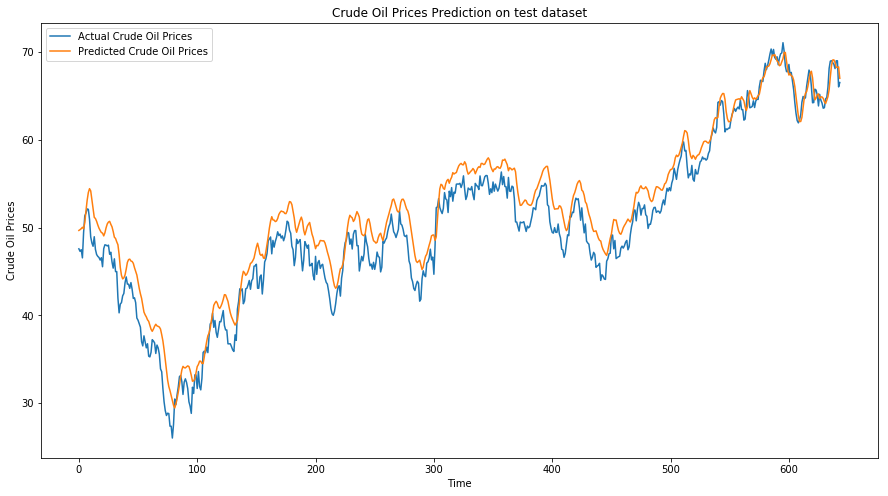

In [29]:
# Visualising the results
actual = df_test[timesteps:len(y_test)].values
predicted = y_test[0:len(y_test) - timesteps]

plt.figure(figsize=[15,8])
plt.plot(actual, label = 'Actual Crude Oil Prices')
plt.plot(predicted, label = 'Predicted Crude Oil Prices')
plt.title('Crude Oil Prices Prediction on test dataset')
plt.xlabel('Time')
plt.ylabel('Crude Oil Prices')
plt.legend()
plt.show()

In [30]:
RMSE = np.sqrt(mean_squared_error(actual,predicted))
print(RMSE)

2.6018661401116177


As it can be seen that LSTMs have a better performance than ARIMA in this case and the crude oil prices have been predicted to a descent extent